### Notes from meeting with Steve 11/19
- spatial analysis component
- show time of fracking events
- Have time to create video since it's time consuming


- Cluster on magnitude?

### Notes from meeting with Steve 12/04
- Explain what *moments* are and include units
- Retain zooming options in Tableau from earthquakes to wells OR add wells as layer to earthquake data
- Injection time data? So far, we have not found dates but there are reports dated as early as 2011
    - The reports that are dated don't contain the locations
- Kriging: https://en.wikipedia.org/wiki/Kriging
- He'll get back to us about finding a good model for continuous data
- Look at past homeworks and follow a similar outline for project


- I suggest to add the regression model

# Experimenting with data :)
*By Kamrine Poels*

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import json
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from pyquery import PyQuery as pq
import requests
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
##### IMPORT THE DATA FRAME FROM 2015
import json
with open("tempdata/df.json") as json_file:
     df = json.load(json_file)
df = pd.read_json(df)

In [3]:
#initialize the dataframe with 1980 data
since_1980_df = pd.DataFrame()
since_1980_df = pd.read_csv('http://wichita.ogs.ou.edu/eq/catalog/1980/1980.csv')

# add additional years
for year in range(1981,2016):
    url = 'http://wichita.ogs.ou.edu/eq/catalog/' + str(year) + '/' + str(year) + '.csv'
    temp_df = pd.read_csv(url)
    # This might not be the most efficient method
    since_1980_df = since_1980_df.append(temp_df)
since_1980_df.head()

,id,origintime,latitude,longitude,depth,err_lon,err_lat,err_depth,err_origintime,county,origin_src,prefmag,pmag_type,pmag_src,mw,mw_src,mblg_ogs,mblg_usgs,ml_ogs,m3hz_ogs,md_ogs,mb,ms,mfa,max_mmi,reafile,reamtime,geom,pdlid,mw_ogs
0,255,1980-01-05 07:11:31.21,35.586,-97.894,5,NaN,NaN,NaN,NaN,CANADIAN,OGS,1.9,M3Hz,OGS,NaN,NaN,1.6,NaN,NaN,1.9,1.7,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E6100000F0A7C64B377958C05EBA490C02CB...,NaN,NaN
1,256,1980-01-12 07:12:56.45,36.453,-97.642,5,NaN,NaN,NaN,NaN,GARFIELD,OGS,1.7,M3Hz,OGS,NaN,NaN,NaN,NaN,NaN,1.7,1.4,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000000C022B87166958C0448B6CE7FB39...,NaN,NaN
2,257,1980-02-03 00:46:30.05,33.994,-97.463,5,NaN,NaN,NaN,NaN,LOVE,OGS,2.2,M3Hz,OGS,NaN,NaN,1.9,NaN,NaN,2.2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000001283C0CAA15D58C0AC1C5A643BFF...,NaN,NaN
3,258,1980-02-05 04:32:35.45,34.046,-97.451,5,NaN,NaN,NaN,NaN,LOVE,OGS,2.1,M3Hz,OGS,NaN,NaN,2.3,NaN,NaN,2.1,1.9,NaN,NaN,NaN,3,NaN,NaN,0101000020E6100000BE9F1A2FDD5C58C0D9CEF753E305...,NaN,NaN
4,259,1980-03-09 03:57:10.56,35.100,-95.100,5,NaN,NaN,NaN,NaN,HASKELL,OGS,1.2,M3Hz,OGS,NaN,NaN,1.4,NaN,NaN,1.2,1.4,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000006666666666C657C0CDCCCCCCCC8C...,NaN,NaN


## Visualizations of earthquake data in 2015:

In [4]:
import time
# We collect the time of each event
year_day = []
for date in df.origintime.values:
    new_date = time.strptime(date, "%Y/%m/%d %H:%M:%S")
    year_day.append(new_date.tm_yday)    
# Group earthquakes by day in 2015
df['year_day'] = year_day
df_byYear = df.groupby('year_day')

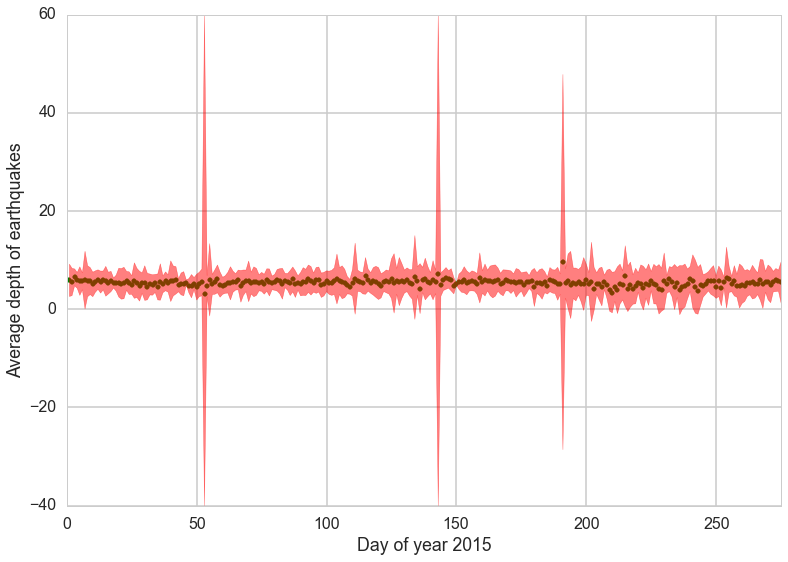

In [5]:
# Initiate vectors of critical values
low = []
up = []
for mean, std in zip(df_byYear["depth"].mean(), df_byYear["depth"].std()):
    # If only one observation, use whole vertical range of graph for error
    if std != std:
        low.append(-40)
        up.append(60)
    # Calculate ~95% 2 sided interval
    else:
        low.append(mean-2*std)
        up.append(mean+2*std)
        
plt.scatter(df_byYear.groups.keys(), df_byYear["depth"].mean(), color = 'g')
plt.fill_between(df_byYear.groups.keys(), low, up, color = 'r', alpha = .5)
plt.xlim(0, 275)
plt.ylim(-40, 60)
plt.xlabel("Day of year 2015")
plt.ylabel("Average depth of earthquakes")

Average magnitude in 2015:  2.54732346241


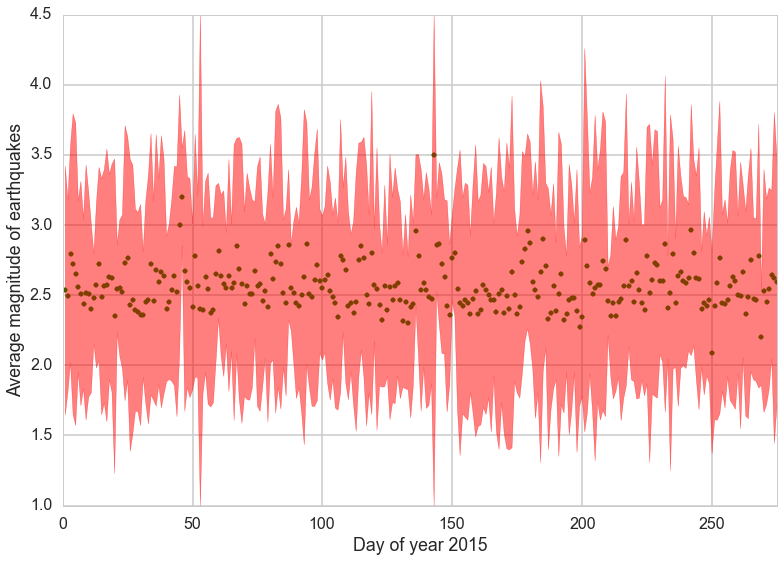

In [6]:
low = []
up = []
for mean, std in zip(df_byYear.prefmag.mean(), df_byYear.prefmag.std()):
    if std != std:
        low.append(1)
        up.append(4.5)
    else:
        low.append(mean-2*std)
        up.append(mean+2*std)
plt.scatter(df_byYear.groups.keys(), df_byYear["prefmag"].mean(), color = 'g')
plt.fill_between(df_byYear.groups.keys(), low, up, color = 'r', alpha = .5)
plt.xlim(0, 275)
plt.ylim(1,4.5)
plt.xlabel("Day of year 2015")
plt.ylabel("Average magnitude of earthquakes")
print "Average magnitude in 2015: ", df.prefmag.mean()

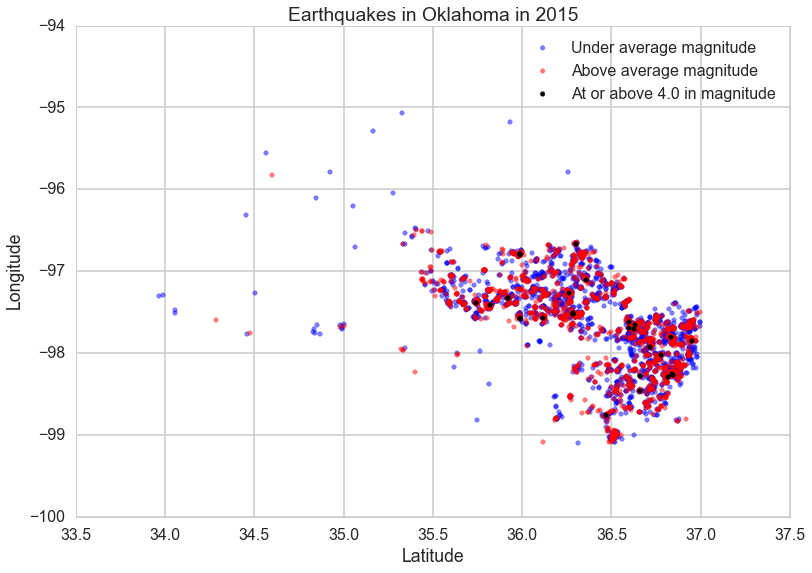

In [7]:
# Separate earthquakes into 3 groups according to magnitude and plot location
avgmag = df.prefmag.mean()
under_avgmag = [df.prefmag.values < avgmag]
above_avgmag = [df.prefmag.values > avgmag]
extreme = [df.prefmag.values >= 4]
plt.scatter(df.latitude.values[under_avgmag], df.longitude.values[under_avgmag], 
            color = 'b', label = "Under average magnitude", alpha =.5)
plt.scatter(df.latitude.values[above_avgmag], df.longitude.values[above_avgmag], color = 'r', 
            label = "Above average magnitude", alpha =.5)
plt.scatter(df.latitude.values[extreme], df.longitude.values[extreme], color = 'k', 
            label = "At or above 4.0 in magnitude")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title("Earthquakes in Oklahoma in 2015")
plt.legend()

There seems to be no area where earthquakes are most severe.

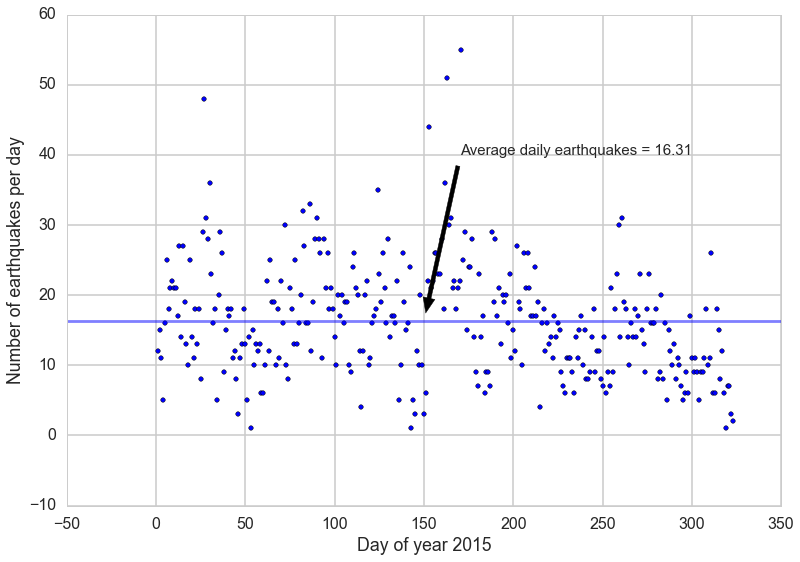

In [8]:
# Plot number of earthquakes per day
plt.scatter(df_byYear.groups.keys(), df_byYear['depth'].count())
plt.ylabel('Number of earthquakes per day')
plt.xlabel("Day of year 2015")
# Add horizontal line of average number of earthquakes per day
plt.axhline(df_byYear['depth'].count().mean(), alpha = .5)
plt.annotate("Average daily earthquakes = %.2f" % round(df_byYear['depth'].count().mean(),2),
             xy = (150,df_byYear['depth'].count().mean()), xytext = (170,40), 
             arrowprops=dict(facecolor='black', shrink=0.05), size = 15)

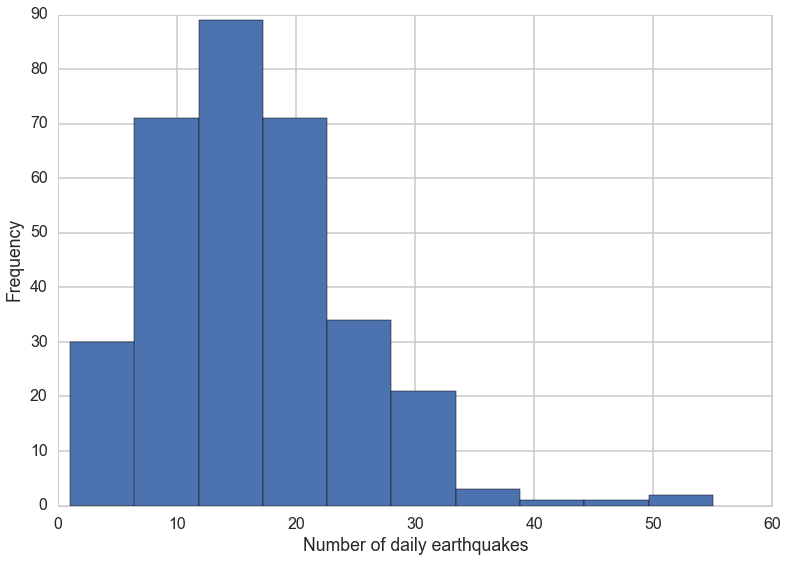

In [9]:
# Plot histogram of daily number of earthquakes
plt.hist(df_byYear['depth'].count().values)
plt.xlabel("Number of daily earthquakes")
plt.ylabel("Frequency")

Seems to follow normal distribution, slightly positively skewed

## Visualizations of earthquake data since 1980

In [10]:
# Extract year of earthquake events
year_day = []
year = []
for date in since_1980_df.origintime.values:
    new_date = time.strptime(date[:19], "%Y-%m-%d %H:%M:%S")
    year_day.append(new_date.tm_yday)
    year.append(new_date.tm_year)
# Add to data frame the day of a year of earthquake
since_1980_df['year_day'] = year_day
# Add to data frame the year of earthquake
since_1980_df['year'] = year
# Group earthquakes by year
since_1980_df_byYear = since_1980_df.groupby('year')

Average magnitude of earthquakes since 1980:  2.19864651359


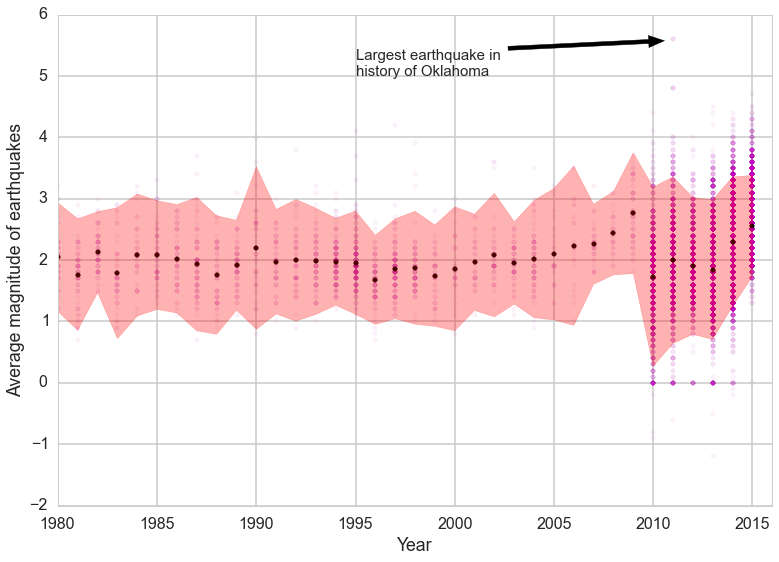

In [11]:
# Plot magnitude of EACH earthquake against year
plt.scatter(since_1980_df.year,since_1980_df.prefmag , color = 'm', alpha = .05)
# Plot average magnitude of earthquakes by year and color two standard errors from mean
plt.scatter(since_1980_df_byYear.groups.keys(), since_1980_df_byYear["prefmag"].mean(), color = 'k')
plt.fill_between(since_1980_df_byYear.groups.keys(), (since_1980_df_byYear["prefmag"].mean()-2*since_1980_df_byYear["prefmag"].std()), 
                 (since_1980_df_byYear["prefmag"].mean()+2*since_1980_df_byYear["prefmag"].std()), color = 'r', alpha = .3)
plt.xlim(1980, 2016)
plt.xlabel("Year")
plt.ylabel("Average magnitude of earthquakes")
plt.annotate("Largest earthquake in \nhistory of Oklahoma", xy = (2011, 5.58), xytext = (1995,5), size =15,
            arrowprops=dict(facecolor='black', shrink=0.05))
print "Average magnitude of earthquakes since 1980: ", since_1980_df.prefmag.mean()

Magnitude seems to remain unaffected despite larger number of detected earthquakes. If most if not all seismometers were present in OK since ~1960, then there is an obvious increase in earthquakes starting in 2010, a year after fracking. 

See http://earthquake.usgs.gov/earthquakes/eqinthenews/2011/usb0006klz/ for largest earthquake in OK

## Quick look at all combined data

In [12]:
all_df = pd.read_csv('http://wichita.ogs.ou.edu/eq/catalog/complete/complete.csv')

In [13]:
# Extract time of each earthquake
year = []
for date in all_df.origintime.values:
    new_date = time.strptime(date[:19], "%Y-%m-%d %H:%M:%S")
    year.append(new_date.tm_year)    
all_df['year'] = year
# Group by year
all_df_byYear = all_df.groupby('year')

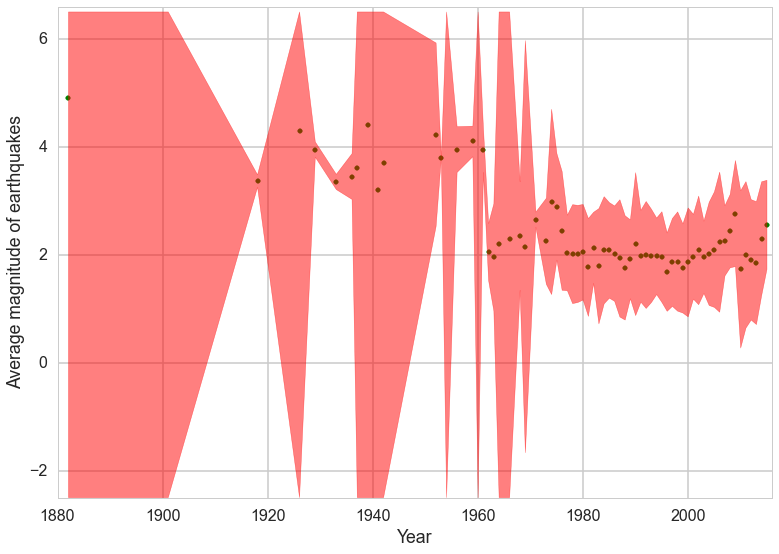

In [14]:
low = []
up = []
for mean, std in zip(all_df_byYear.prefmag.mean(), all_df_byYear.prefmag.std()):
    if std != std:
        low.append(-2.5)
        up.append(6.5)
    else:
        low.append(mean-2*std)
        up.append(mean+2*std)
plt.scatter(sorted(all_df_byYear.groups.keys()), all_df_byYear.prefmag.mean(), color = 'g')
plt.fill_between(sorted(all_df_byYear.groups.keys()), low, up, color = 'r', alpha = .5)
plt.xlim(1880, 2016)
plt.ylim(-2.5,6.6)
plt.xlabel("Year")
plt.ylabel("Average magnitude of earthquakes")

Ew, this looks ugly. It's best we work with data since 1980...

# Download *Fracking* data

Data taken from http://www.occeweb.com/og/ogdatafiles2.htm. Just so we can say we looked at fracking data :)

In [15]:
import csv
with open('tempdata/2013_FracFocusReport.txt') as inputfile:
    filetemp = list(csv.reader(inputfile))
# Initiate dictionary for data
fracfocus = {}
# Get names of features
new_keys = filetemp[0][0].split("\t")
# Add names of features as keys to dictionary fracfocus. Each element is a list
for key in new_keys:
    fracfocus[key] = []
for line in filetemp[1:]:
    new_items = line[0].split('\t')
    # If data is missing, don't add observation/site to dictionary
    if len(new_items) == 15:
        for key, item in zip(new_keys, new_items):
            try:
                fracfocus[key].append(float(item))
            except:
                fracfocus[key].append(item)
# Convert to Pandas data frame
fracfocus = pd.DataFrame(fracfocus)
# Get observations in Oklahoma
fracfocus = fracfocus[fracfocus.state == 'Oklahoma']
print fracfocus.shape
fracfocus.head()

(852, 15)


,api,county,datum,fracture_date,latitude,longitude,operator,pdf_seqid,production_type,published,r_seqid,state,total_water_volume,true_vertical_depth,well_name
66,35-003-22379-00-00,Alfalfa,NAD27,2012-10-03,36.870004,-98.245130,SandRidge Energy,44827,Oil,2013-03-20 15:19:23.619209,41565,Oklahoma,1500114,5183,Fox 2810 3-26H
92,35-003-22495-00-00,Alfalfa,NAD27,2013-03-08,36.839823,-98.196894,SandRidge Energy,47442,Oil,2013-04-24 11:19:17.892085,44833,Oklahoma,1792182,5234,Stein Trust 2709 2-8H
99,35-003-22556-00-00,Alfalfa,NAD27,2013-03-28,36.958085,-98.356177,SandRidge Energy,48458,Oil,2013-05-03 12:19:49.346480,45710,Oklahoma,1415250,4898,Cecil 2911 4-26H
100,35-003-22511-00-00,Alfalfa,NAD27,2013-03-21,36.986320,-98.208290,SandRidge Energy,48473,Oil,2013-05-03 12:19:51.102388,45712,Oklahoma,1443942,4878,West 2909 4-18H
101,35-053-23208-00-00,Grant,NAD27,2013-03-22,36.766688,-97.796543,SandRidge Energy,48472,Oil,2013-05-03 12:20:23.493616,45741,Oklahoma,1772951,5105,Jackson 2606 3-1H


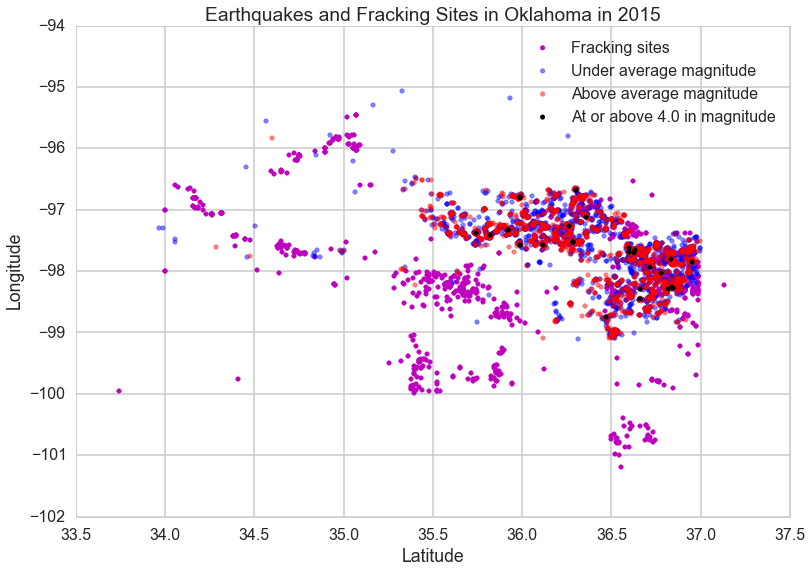

In [16]:
# Plot location of fracking sites
# CHANGE COLORS, USE COLOR BREWER
plt.scatter(fracfocus.latitude, fracfocus.longitude, label = 'Fracking sites', color = 'm')
plt.scatter(df.latitude.values[under_avgmag], df.longitude.values[under_avgmag], 
            color = 'b', label = "Under average magnitude", alpha =.5)
plt.scatter(df.latitude.values[above_avgmag], df.longitude.values[above_avgmag], color = 'r', 
            label = "Above average magnitude", alpha =.5)
plt.scatter(df.latitude.values[extreme], df.longitude.values[extreme], color = 'k', 
            label = "At or above 4.0 in magnitude")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title("Earthquakes and Fracking Sites in Oklahoma in 2015")
plt.legend()

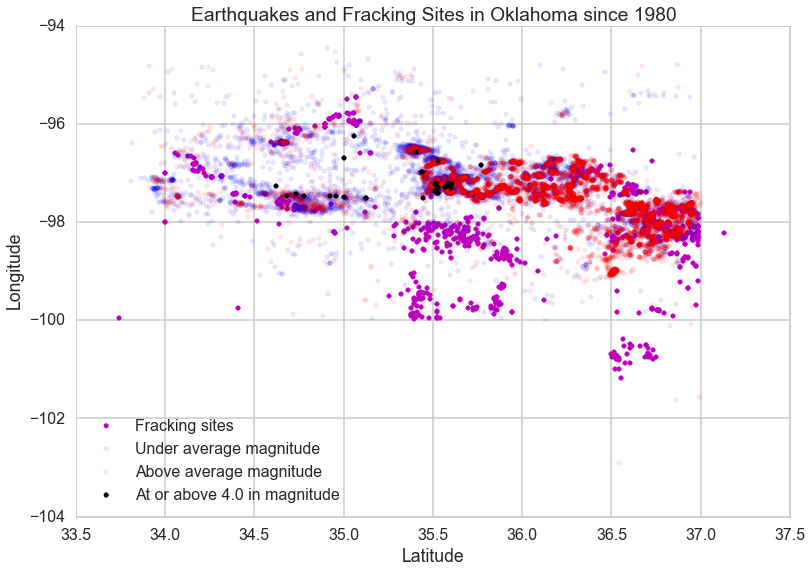

In [17]:
avgmag = since_1980_df.prefmag.mean()
under_avgmag = [since_1980_df.prefmag.values < avgmag]
above_avgmag = [since_1980_df.prefmag.values > avgmag]
plt.scatter(fracfocus.latitude, fracfocus.longitude, label = 'Fracking sites', color = 'm')
plt.scatter(since_1980_df.latitude.values[under_avgmag], since_1980_df.longitude.values[under_avgmag], 
            color = 'b', label = "Under average magnitude", alpha =.1)
plt.scatter(since_1980_df.latitude.values[above_avgmag], since_1980_df.longitude.values[above_avgmag], color = 'r', 
            label = "Above average magnitude", alpha =.1)
plt.scatter(since_1980_df.latitude.values[extreme], since_1980_df.longitude.values[extreme], color = 'k', 
            label = "At or above 4.0 in magnitude")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title("Earthquakes and Fracking Sites in Oklahoma since 1980")
plt.legend(loc =3)

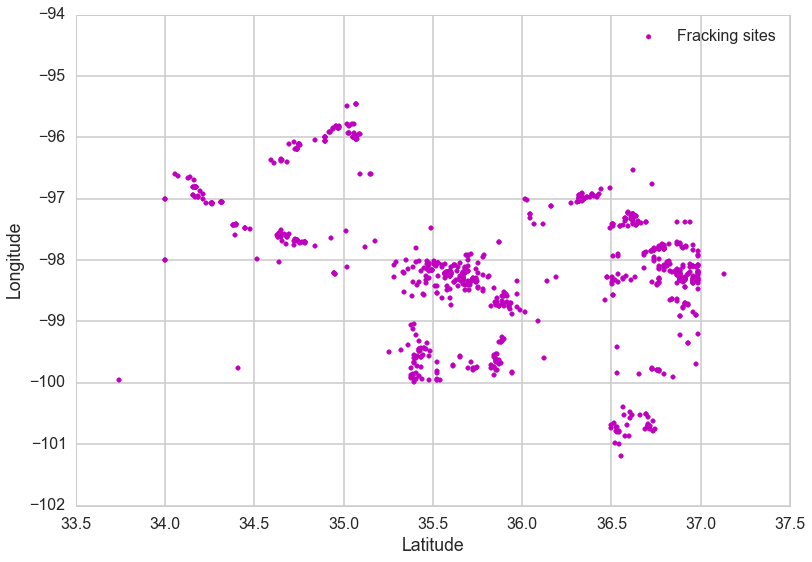

In [18]:
plt.scatter(fracfocus.latitude, fracfocus.longitude, label = 'Fracking sites', color = 'm')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.ylim(-102,-94)
plt.legend()

## Water disposal wells: predicted inducer of earthquakes

In [19]:
drill_file = pd.read_excel('tempdata/all_uic_wells.xls')
drill_file
# This file has a lot of missing data. We will omit the observations that are missing in the features/factors of interest
# Select factors of interest
factors = ['MAXPRESSURE', 'MAXRATE', 'FORMATION_TOP_DEPTH', 'FORMATION_BOTTOM_DEPTH', 'PACKERDEPTH', 
           'LATTITUDE', 'LONGITUDE']
# Initiate list of rows that have no missing data
keep_rows = []
for i in range(len(drill_file.STATUS)):
    for factor in factors:
        if (type(drill_file[factor][i]) == float):
            keep_rows.append(i)
            break
# Select non-missing data
drilldf = drill_file.iloc[keep_rows]
# Select only factors of interest
drilldf = drilldf[factors]
drilldf.shape

(16343, 7)

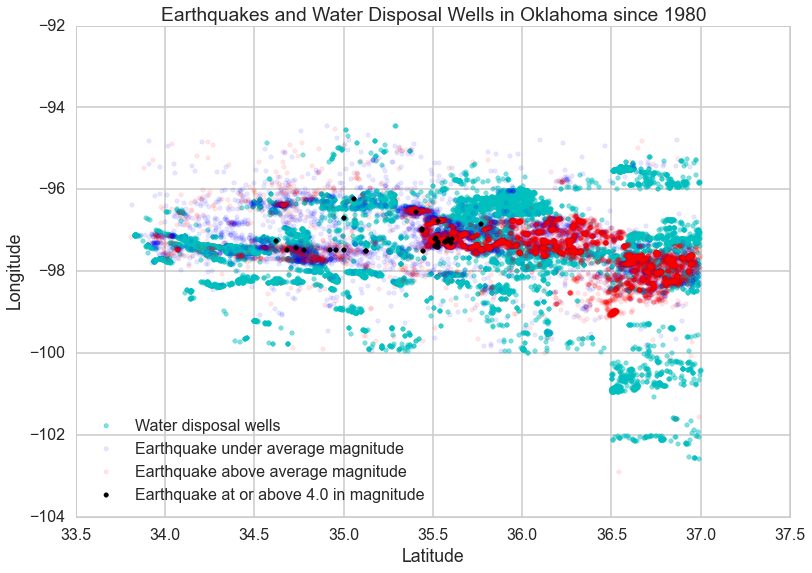

In [20]:
# Plot location of water disposal wells with earthquake data previously separated
plt.scatter(drilldf.LATTITUDE, drilldf.LONGITUDE, color = 'c', label = 'Water disposal wells', alpha = .5)
plt.scatter(since_1980_df.latitude.values[under_avgmag], since_1980_df.longitude.values[under_avgmag], 
            color = 'b', label = "Earthquake under average magnitude", alpha =.1)
plt.scatter(since_1980_df.latitude.values[above_avgmag], since_1980_df.longitude.values[above_avgmag], color = 'r', 
            label = "Earthquake above average magnitude", alpha =.1)
plt.scatter(since_1980_df.latitude.values[extreme], since_1980_df.longitude.values[extreme], color = 'k', 
            label = "Earthquake at or above 4.0 in magnitude")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title("Earthquakes and Water Disposal Wells in Oklahoma since 1980")
plt.legend(loc =3)

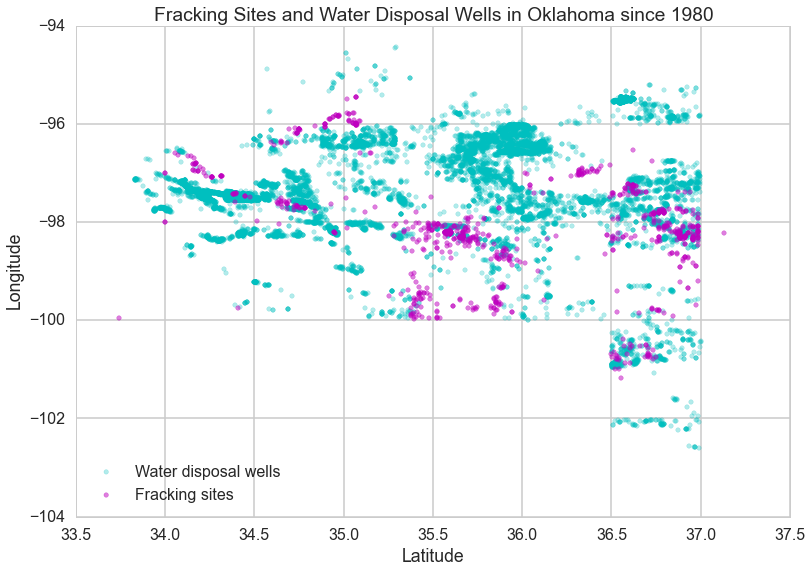

In [21]:
plt.scatter(drilldf.LATTITUDE, drilldf.LONGITUDE, color = 'c', label = 'Water disposal wells', alpha = .3)
plt.scatter(fracfocus.latitude, fracfocus.longitude, label = 'Fracking sites', color = 'm', alpha = .5)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title("Fracking Sites and Water Disposal Wells in Oklahoma since 1980")
plt.legend(loc =3)

## Data of Wells with volume injections

In [82]:
wellvol = pd.read_excel('tempdata/wells.xlsx')
wellvol.head()
# Column X = longitude
# Column Y = latitude
# Column Volume = liters of injected water.

,API,WellName,WellNumber,WellStatus,WellType,Wellkey,Formationkey,FormationCode,Name,TopDepth,X,Y,PM,RangeDir,Range,TownshipDir,Township,Sec,Quarter,QuarterQuarter,QuarterQuarterQuarter,QuarterQuarterQuarterQuarter,QuarterTownship,SALTWATER,ISDELETE,ORDERNUMBER,STATUS,MODIFYDATE,VolumeType,Volume,Packer,ReportYear,Month
0,3500300026,SE EUREKA UNIT-TUCKER #1,21,AC,2RIn,NaN,NaN,000VARS,VARIOUS,NaN,-98.21826,36.900324,Indian,W,10,N,28,13,SE4,CSE4,,,NaN,1,0,133856,ACCEPTED,2014-05-12 14:51:37.530,NaN,0,TUBING - 4850,2013,FEBRUARY
1,3500300026,SE EUREKA UNIT-TUCKER #1,21,AC,2RIn,NaN,NaN,000VARS,VARIOUS,NaN,-98.21826,36.900324,Indian,W,10,N,28,13,SE4,CSE4,,,NaN,1,0,133856,ACCEPTED,2014-05-12 14:51:37.530,NaN,2800,TUBING - 4850,2013,JUNE
2,3500300026,SE EUREKA UNIT-TUCKER #1,21,AC,2RIn,NaN,NaN,000VARS,VARIOUS,NaN,-98.21826,36.900324,Indian,W,10,N,28,13,SE4,CSE4,,,NaN,1,0,133856,ACCEPTED,2014-05-12 14:51:37.530,NaN,1149,TUBING - 4850,2013,MAY
3,3500300026,SE EUREKA UNIT-TUCKER #1,21,AC,2RIn,NaN,NaN,000VARS,VARIOUS,NaN,-98.21826,36.900324,Indian,W,10,N,28,13,SE4,CSE4,,,NaN,1,0,133856,ACCEPTED,2014-05-12 14:51:37.530,NaN,1300,TUBING - 4850,2013,OCTOBER
4,3500300026,SE EUREKA UNIT-TUCKER #1,21,AC,2RIn,NaN,NaN,000VARS,VARIOUS,NaN,-98.21826,36.900324,Indian,W,10,N,28,13,SE4,CSE4,,,NaN,1,0,133856,ACCEPTED,2014-05-12 14:51:37.530,NaN,1666,TUBING - 4850,2013,NOVEMBER


In [93]:
# Clean up data by picking correct coordinates and delete missing data
wellvol = wellvol[['X', 'Y', 'Volume']]
wellvol = wellvol[np.isfinite(wellvol['X'])]
wellvol = wellvol[np.isfinite(wellvol['Y'])]
wellvol = wellvol[np.isfinite(wellvol['Volume'])]
welldf = wellvol[(wellvol.X >= -102.918) & (wellvol.X <= -94.466)]
welldf = welldf[(welldf.Y >= 33.811) & (welldf.Y <= 36.99869)]
welldf.shape

(102190, 3)

## Linear Regression

We break the area into subregions, count the number of earthquakes and number of disposal wells. Perform linear regression.

In [96]:
# Load package for linear model
import statsmodels.formula.api as sm
# Separate data into areas
# Observe extreme values
print min(since_1980_df.longitude), max(since_1980_df.longitude)
print min(welldf.X), max(welldf.X)
print min(since_1980_df.latitude), max(since_1980_df.latitude)
print min(welldf.Y), max(welldf.Y)
# Make ranges
xregions1 = np.arange(33.5, 37., .5); xregions2 = np.arange(34., 37.5, .5); xregions = zip(xregions1, xregions2)
yregions1 = np.arange(-103.,-94. , .5); yregions2 = np.arange(-102.5 ,-93.5, .5); yregions = zip(yregions1, yregions2)
regions = []
# Return a tuple. First tuple is latitude, second is longitude.
for x in xregions:
    for y in yregions:
        regions.append((x,y))
len(regions)

-102.918 -94.466
-102.59469 -94.68911
33.811 36.99869
33.8307222222 36.998362


126

In [97]:
locdict = dict(zip(regions, range(len(regions))))

In [99]:
def find_region(rowquake):
    for region in regions:
        if (rowquake['latitude'] < region[0][1]) \
        & (rowquake['latitude'] >= region[0][0]) \
        & (rowquake['longitude'] < region[1][1]) \
        & (rowquake['longitude'] >= region[1][0]):
                reg = locdict[region]
                break
    return 1, 0, rowquake['year'], reg, 0
    
quakes = since_1980_df.apply(find_region, axis=1)
quakedf = {}; quakedf['quakes'] = []; quakedf['wells'] = []; quakedf['year'] = []; quakedf['region'] = []
quakedf['Volume'] = []
for quake, well, year, region, press in quakes:
    quakedf['quakes'].append(quake); quakedf['wells'].append(well); quakedf['year'].append(year)
    quakedf['region'].append(region); quakedf['Volume'].append(press)
quakedf =  pd.DataFrame(quakedf)

In [101]:
# Same function as above but for wells
def find_region(rowquake):
    for region in regions:
        if (rowquake['Y'] < region[0][1]) \
        & (rowquake['Y'] >= region[0][0]) \
        & (rowquake['X'] < region[1][1]) \
        & (rowquake['X'] >= region[1][0]):
                reg = locdict[region]
                break
    return 0, 1, 2009, reg, rowquake['Volume'] # WE ASSUME THAT THE WELLS STARTED IN 2009. WE NEED MORE DATA TO PROVE THIS

wells = welldf.apply(find_region, axis = 1)
welldf = {}; welldf['quakes'] = []; welldf['wells'] = []; welldf['year'] = []; welldf['region'] = []
welldf['Volume'] = []
for quake, well, year, region, press in wells:
    welldf['quakes'].append(quake); welldf['wells'].append(well); welldf['year'].append(year)
    welldf['region'].append(region); welldf['Volume'].append(press)
welldf =  pd.DataFrame(welldf)

In [102]:
datadf = pd.concat([quakedf, welldf]) # Some maxpressure's are empty. Fix this
datadf['year'] = 1*(datadf['year'] >= 2009)
datadf_reg = datadf.groupby(['region', 'year']).sum().reset_index()
#type(datadf_reg.max_pressure)

In [112]:
datadf_reg.head()

,region,year,Volume,quakes,wells
0,10,0,0,8,0
1,10,1,1844911,1,372
2,11,0,0,11,0
3,11,1,1577855,68,360
4,12,0,0,1,0


In [120]:
olsQuakes = sm.ols(formula = 'quakes ~ wells + year + Volume + wells*Volume', data = datadf_reg).fit()
print olsQuakes.summary()

                            OLS Regression Results                            
Dep. Variable:                 quakes   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     7.239
Date:                Sun, 06 Dec 2015   Prob (F-statistic):           2.49e-05
Time:                        23:34:37   Log-Likelihood:                -1110.3
No. Observations:                 146   AIC:                             2231.
Df Residuals:                     141   BIC:                             2246.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       23.2429     59.105      0.393   